In [1]:
import jax
import optax
import equinox as eqx
import matplotlib.pyplot as plt

from jax import numpy as jnp, random, config
from model import *
from pde import *
from derivative import *
from residual import *
from sampler import *

config.update("jax_enable_x64", True)
key = random.PRNGKey(1312)
key, subkey = random.split(key)

In [2]:
# initialize model:
model = PINN(key=subkey, width=16, depth=4)

# initialize the pde:
alpha_phi = jnp.float64(9.62e-5)
omega_phi = jnp.float64(1.663e7)
A         = jnp.float64(5.35e7)
M         = jnp.float64(8.5e-10) / (2 * A)
L         = jnp.float64(1e-11)
c_se       = jnp.float64(1.0)
c_le       = jnp.float64(5100/1.43e5)
pde = PDE(alpha_phi = alpha_phi, omega_phi = omega_phi, M = M, A = A, L = L, c_se = c_se, c_le = c_le)

# initialize the derivative class:
deriv = Derivative()

# initialize the residual class:
x_span = (-0.5, 0.5)
x_coef = 1.0 * 1e4
t_span = (0.0, 1.0)
t_coef = 1.0 * 1e-5
residual = Residual(x_coef, t_coef, pde, deriv)

# initialize the sampler:
sample_size = {"ic": 128, "bc": 64, "colloc_x": 32, "colloc_t": 32, "adapt": 512}
subsample_size = {"ic": 32, "bc": 32, "colloc": 128, "adapt": 128}
sampler = Sampler(x_span, t_span, sample_size, subsample_size, residual, noise=1.0)

In [3]:
# initialize the hyper parameters
total_step = 8000   # Total training steps
sp1 = 20  # Resampling frequency
sp2 = 20  # NTK weighting frequency
sp3 = 100  # log frequency

# initialize the optimizer
optimizer = optax.adam(1e-3)
params, static = eqx.partition(model, eqx.is_inexact_array)
opt_state = optimizer.init(params)

# initialize the samples
x, t = sampler.get_sample(key, model, which_criterion = "residual")

# initialize the carry
# init = (key, step, x, t, weight, params, static, optimizer, best_loss, best_params)
weight = {'ic':1.0, 'bc':1.0, 'ch':1.0, 'ac':1.0}
init = (key, 0, x, t, weight, params, opt_state, jnp.inf, params)

In [4]:
# log function
def log_fn(step, weight, loss):
    keys = ['ic', 'bc', 'ac', 'ch']
    labels = [k.upper() for k in keys]

    weight_array = jnp.array([weight[k] for k in keys])
    loss_array = jnp.array([loss[k] for k in keys])
    total_loss = jnp.dot(weight_array, loss_array)

    jax.debug.print("Step {step}: total_loss = {total:.4e}", step=step, total=total_loss)

    jax.debug.print(
        "  Weights  ['ic', 'bc', 'ac', 'ch'] = [{:.4e},{:.4e},{:.4e},{:.4e}]",
        weight_array[0],weight_array[1],weight_array[2],weight_array[3]
    )
    
    jax.debug.print(
        "  Loss     ['ic', 'bc', 'ac', 'ch'] = [{:.4e},{:.4e},{:.4e},{:.4e}]",
        loss_array[0],loss_array[1],loss_array[2],loss_array[3]
    )

@jax.jit
def train_step(carry, _):
    # unpack carry
    key, step, x, t, weight, params, opt_state, best_loss, best_params = carry

    # new keys and reconstruct model
    key, subkey1, subkey2 = random.split(key, 3)
    model_temp = eqx.combine(params, static)

    # ============ Conditionally resample points ============
    x, t = jax.lax.cond(
        step % sp1 == 0,
        lambda _: sampler.get_sample(subkey1, model_temp, which_criterion = "residual"),
        lambda _: (x, t),
        operand=None,
    )

    # ============ Conditionally recompute weights ============
    def update_weight(key, model, x, t):
        x_rand,t_rand = sampler.get_subsample(key,x,t)
        return residual.compute_ntk_weights(model, x_rand, t_rand, batch_size = 32)

    weight = jax.lax.cond(
        step % sp2 == 0,
        lambda _: update_weight(subkey2, model_temp, x, t),
        lambda _: weight,
        operand=None,
    )

    # ============ Loss function ============
    def loss_fn(params, static, step, x, t, weight):
        # reconstruct model and compute loss
        model_temp = eqx.combine(params, static)
        loss = residual.compute_loss(model_temp, x, t)
        
        # Convert to arrays for dot product
        names = ['ic', 'bc', 'ac', 'ch']
        weight_array = jnp.array([weight[k] for k in names])
        loss_array = jnp.array([loss[k] for k in names])
    
        # Logging if required
        jax.lax.cond(step % sp3 == 0, lambda _: log_fn(step, weight, loss), lambda _: None, operand=None)
        return jnp.dot(weight_array, loss_array)

    # ============ compute loss and update ============
    loss, grads = jax.value_and_grad(loss_fn)(params, static, step, x, t, weight)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # =========== save the best model ============
    best_loss, best_params = jax.lax.cond(
        best_loss > loss,
        lambda _: (loss, params),
        lambda _: (best_loss, best_params),
        operand=None,
    )
    return (key, step+1, x, t, weight, params, opt_state, best_loss, best_params), loss
    

In [5]:
# -- Run Training Loop --
final_carry, loss_history = jax.lax.scan(train_step, init, xs=None, length=total_step + 1)

Step 0: total_loss = 2.3983e+00
  Weights  ['ic', 'bc', 'ac', 'ch'] = [2.0544e+00,1.9490e+00,4.1727e+05,6.6523e+03]
  Loss     ['ic', 'bc', 'ac', 'ch'] = [5.8088e-01,5.8592e-01,5.1158e-08,6.2579e-06]
Step 100: total_loss = 4.0866e-01
  Weights  ['ic', 'bc', 'ac', 'ch'] = [2.0677e+00,1.9569e+00,1.4246e+06,1.8672e+02]
  Loss     ['ic', 'bc', 'ac', 'ch'] = [1.2290e-01,5.2213e-02,3.2662e-08,3.1189e-05]
Step 200: total_loss = 2.4466e-01
  Weights  ['ic', 'bc', 'ac', 'ch'] = [2.0699e+00,2.1102e+00,1.9968e+06,2.3257e+01]
  Loss     ['ic', 'bc', 'ac', 'ch'] = [8.3212e-02,1.6129e-02,1.3511e-08,4.9039e-04]
Step 300: total_loss = 1.6150e-01
  Weights  ['ic', 'bc', 'ac', 'ch'] = [2.5074e+00,2.3654e+00,2.4041e+06,5.6049e+00]
  Loss     ['ic', 'bc', 'ac', 'ch'] = [5.7442e-02,2.1570e-03,3.1915e-09,8.3723e-04]
Step 400: total_loss = 1.6045e-01
  Weights  ['ic', 'bc', 'ac', 'ch'] = [5.3426e+00,5.1244e+00,1.2767e+07,1.6190e+00]
  Loss     ['ic', 'bc', 'ac', 'ch'] = [2.6860e-02,8.2127e-04,7.5733e-10,1.89

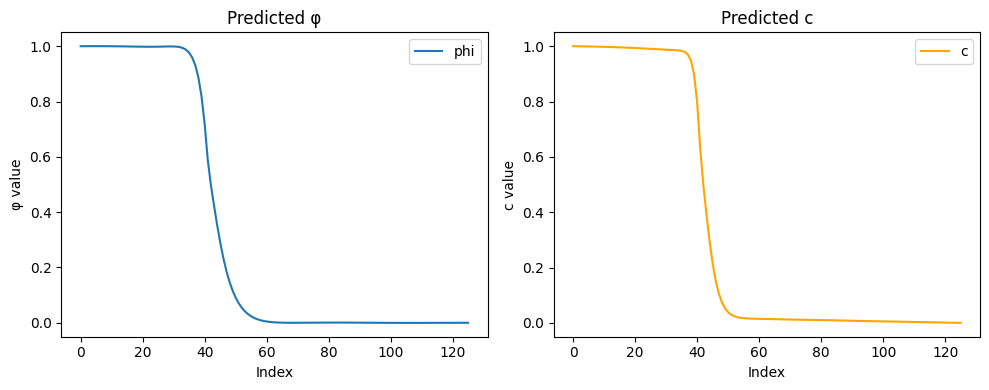

In [7]:
_, _, _, _, _, final_params, _, best_loss, best_params = final_carry
model_final = eqx.combine(best_params, static)
phi_pred, c_pred  = model_final(x["ic"], 0.5 * jnp.ones_like(x["ic"]))

# Assuming phi_pred and c_pred are 1D arrays of same length
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(phi_pred, label="phi")
axes[0].set_title("Predicted φ")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("φ value")
axes[0].legend()

axes[1].plot(c_pred, label="c", color="orange")
axes[1].set_title("Predicted c")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("c value")
axes[1].legend()

plt.tight_layout()
plt.show()